In [1]:
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

In [2]:
%matplotlib inline

from PIL import Image
from PIL import ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
import math
import tabulate


def plot_images(images_with_names):
    plt.figure(figsize=(10*5, 4.8*5), constrained_layout=False)

    for counter, (image, name) in enumerate(images_with_names, 151):
        plt.subplot(counter)
        plt.imshow(image, "gray")
        plt.title(name)

    plt.show()
    
    
def binarize_image(image, threshold):
    image = image.convert('LA')
    image = np.array(image)
    for raw in image:
        for column in raw:
            column[0] = 255 if column[0] < threshold else 0
    return Image.fromarray(image)


def get_centroids(image):
    label_img = label(image)
    regions = regionprops(label_img)
    return np.array([region.centroid for region in regions])


def points_to_image(image, points):
    array = np.array(image)
    for y, x in points:
        array[int(y), int(x)] = [0, 255]

    image = Image.fromarray(array)
    return image


In [3]:

# set current_directory with Path function cwd() [Current Working Directory]
current_directory = Path.cwd()

# path to access our image
image_path = current_directory.joinpath('img/unprepared_image.png')

# print(f'Current directory: {current_directory}')
# print(f'Image path: {image_path}')

# open image with Pillow
raw_image = Image.open(image_path)
# convert image to grayscale
image_grayscale = raw_image.convert(mode='LA')

# Декодирование позиции

## Обработка изображения


В умных ручках используются инфракрасные камеры и прозрачные в этом спектре
чернила. За счет этого чернила не мешают позиционироваться на листах при письме.
Камера же делает снимки только тогда, когда на стержень оказывается давление.
Поэтому задача оцифровки рукописного текста и изображений в случае умных ручек
сводится к правильному декодированию последовательности таких снимков в координаты.


Первым этапом декодирования, после получения изображения, содержащего блок
минимального размера (8x8), является препроцессинг. **Исходное изображение (а)** 
переводится в **оттенки серого (б)**, а потом **бинаризуется (в)** (значение порога выведено 
эмпирически). Из получившегося изображения необходимо **удалить шумы (г)**, чтобы убрать 
артефакты печати и повысить качество распознавания. Для этого используется медианный 
фильтр (значение которого также выведено эмпирически).

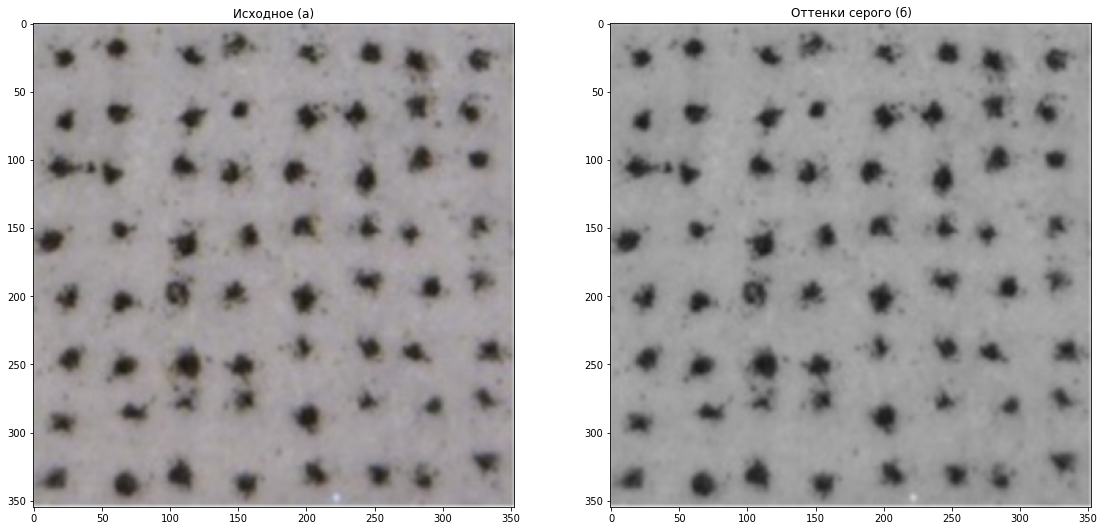

In [4]:
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plot_images([
    (raw_image, 'Исходное (а)'), 
    (image_grayscale, 'Оттенки серого (б)')
])

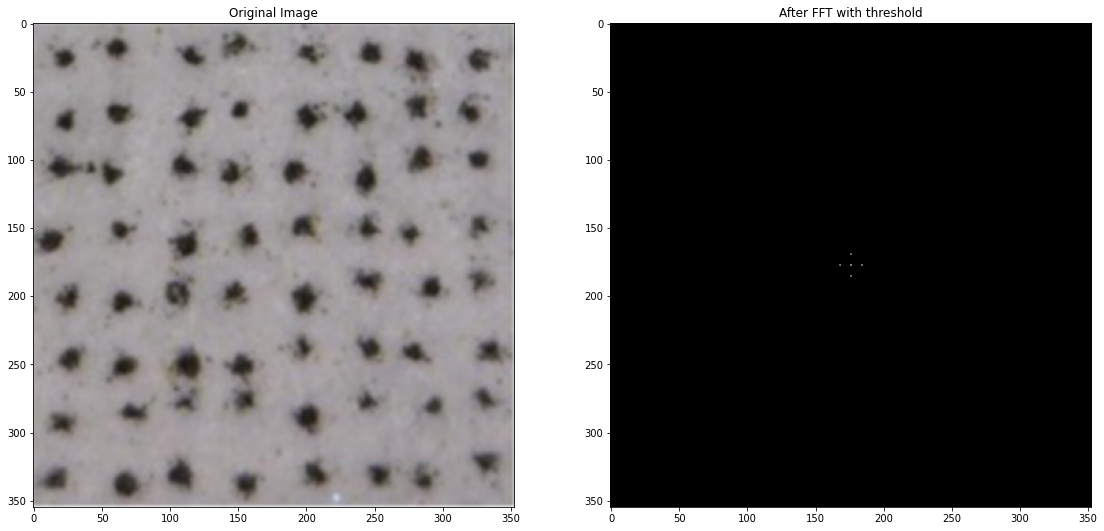

In [30]:
import cv2

def filter_with_threshold(matrix, threshold):
    filtered = np.zeros_like(matrix)
    points = []
    for y in range(len(filtered)):
        raw = []
        need_append = False
        for x in range(len(filtered[y])):
            if matrix[y, x] > threshold:
                filtered[y, x] = matrix[y, x]
                raw.append((x, y))
                need_append = True
                
        if need_append:
            points.append(raw)
                
                
    return (np.log(1+np.abs(filtered)), points)


def fft(image_for_fft, threshold):
    image_for_cv = cv2.cvtColor(np.array(image_for_fft), cv2.COLOR_RGB2GRAY)    

    img_c2 = np.fft.fft2(image_for_cv)
    img_c3 = np.fft.fftshift(img_c2)
    img_c5 = filter_with_threshold(img_c3, img_c3.max() * threshold)
    
    return img_c5


image_fft, fft_points = fft(raw_image, 0.03125)

plot_images([
    ( raw_image, "Original Image" ),
    ( image_fft, "After FFT with threshold" )
])

In [31]:
print(fft_points)

[[(176, 169)], [(168, 177), (176, 177), (184, 177)], [(176, 185)]]


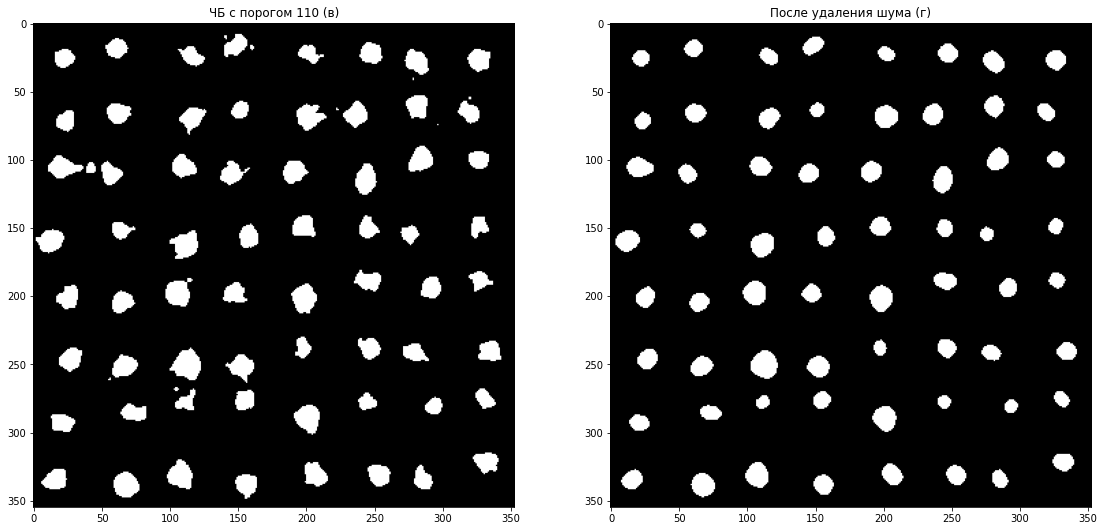

In [6]:
threshold_for_bw = 110
black_white_image = binarize_image(image_grayscale, threshold=threshold_for_bw)
deleted_noise_image = black_white_image.filter(ImageFilter.MedianFilter(11))

plot_images([
    (black_white_image, f'ЧБ с порогом {threshold_for_bw} (в)'), 
    (deleted_noise_image, 'После удаления шума (г)')
])

Нужно отметить, что в данном изложении алгоритма используются относительно выровненные изрбражения.
Ручка же делает снимки под наклоном в силу того, что это происходит при письме. Причем важно учесть,
что угол наклона может варьироваться очень сильно, что делает позиционирование невозможным без
выравнивания изображения.

Точки исходного изображения представляются на бинаризованном изображении в виде областей белых пикселей.
С помощью инструмента regionprops из пакета skimage находим центроиды данных областей (**изображение (а)** показывает бинарное изображение с наложенными центроидами, а **изображение (б)** только центроиды). 

Важно отметить, что в случае неправильной фильтрации изображения, слишком низком пороге для бинаризации, некачественного исходного снимка, либо поврежденного бумажного носителя может возникнуть ситуация, когда возникнут лишние точки, либо пропадут нужные. В случае первых двух проблем нужно провести эксперименты для вычисления оптимальных параметров, а в случае других - попробовать поискать на изображении другой валидный блок, если таких нет, а коррекция ошибок не справляется - спозиционироваться невозможно.

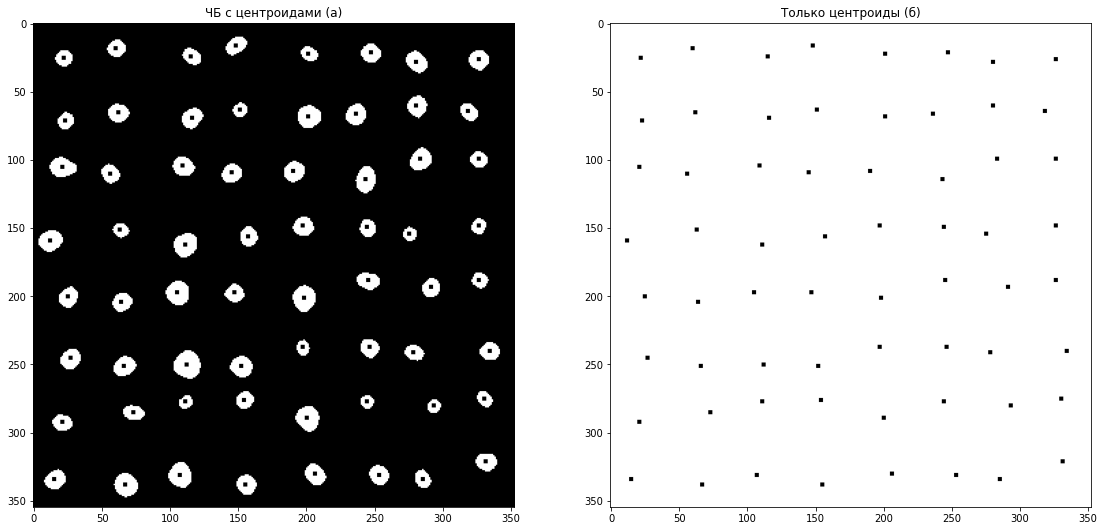

In [7]:
pixels_array = np.array(deleted_noise_image.convert(mode='1'))
centroids = get_centroids(pixels_array) 


centroids_with_neighbours = []
for point in centroids:
    x, y = point
    offsets = [-1, 0, 1]
    for offset_x in offsets:
        for offset_y in offsets:
            centroids_with_neighbours.append((x + offset_x, y + offset_y))

centroids_zero_array = np.zeros_like(deleted_noise_image)
for y in range(deleted_noise_image.height):
    for x in range(deleted_noise_image.width):
        centroids_zero_array[y, x] = [255, 255]

centroids_image = points_to_image(centroids_zero_array, centroids_with_neighbours)
plot_images([
    (points_to_image(deleted_noise_image, centroids_with_neighbours), 'ЧБ с центроидами (а)'),
    (centroids_image, 'Только центроиды (б)')
])

In [8]:

def print_columns(it):
    display(tabulate.tabulate(it.transpose(), [f'Col {i}' for i in range(1, N + 1)], tablefmt="html"))

    
N = int(math.sqrt(len(centroids)))
centroids_in_grid = centroids[np.argsort(centroids[:, 0])].reshape(N, N, 2)

for i in range(N):
    centroids_in_grid[i] = centroids_in_grid[i][np.argsort(centroids_in_grid[i][:, 1])]
    
x_coordinates_of_centroids = centroids_in_grid[:, :, 0]
average_x = x_coordinates_of_centroids.mean(axis = 1)

In [9]:
def print_rows(it):
    display(tabulate.tabulate(
        [[f'Row {i}'] + list(row) for i, row in zip(range(1, N + 1), it.transpose())], 
        [], tablefmt="html"))

    
y_coordinates_of_centroids = centroids_in_grid[:, :, 1]
average_y = y_coordinates_of_centroids.mean(axis = 0)

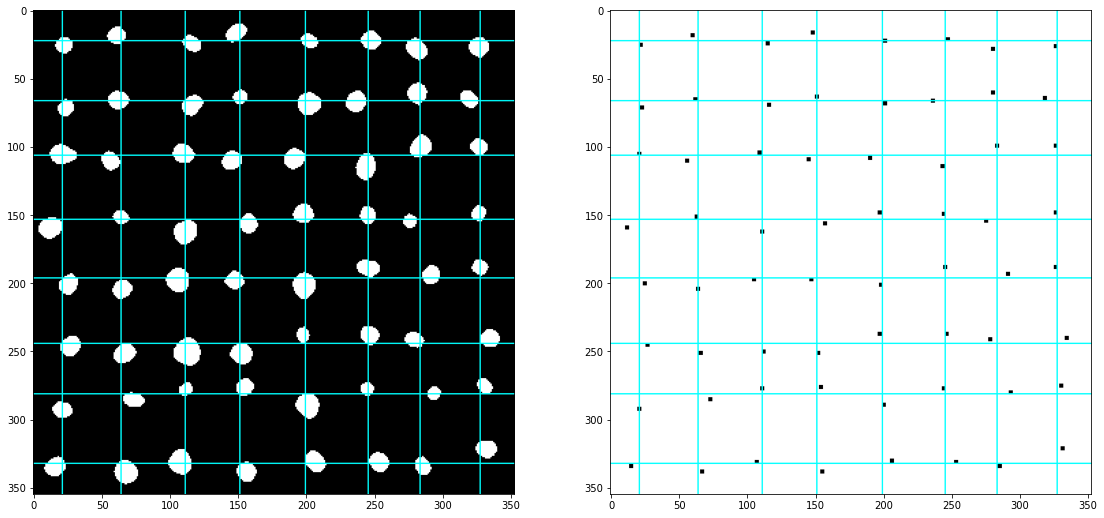

In [10]:
from PIL import ImageDraw

def add_virtual_lines(image, values_x, values_y):
    virtual_lines = image.convert(mode='RGB')
    drawer = ImageDraw.Draw(virtual_lines)
    color = (0, 255, 255)
    for x in values_x:
        drawer.line([(x, 0), (x, virtual_lines.height)], fill=color, width=1)

    for y in values_y:
        drawer.line([(0, y), (virtual_lines.width, y)], fill=color, width=1)
    
    return virtual_lines

plot_images([
    (add_virtual_lines(deleted_noise_image, average_y, average_x), ''),
    (add_virtual_lines(centroids_image, average_y, average_x), '')
])

## Вычисление позиций точек

Координаты точек раскладываются в две таблицы - одна для координат X (Таблица 1), 
а вторая для координат Y (Таблица 2). 

In [11]:
print('Таблица 1. X-координаты точек')
print_columns(x_coordinates_of_centroids)

Таблица 1. X-координаты точек


Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8
25.3475,71.3246,105.429,159.215,200.747,245.988,292.696,334.488
18.1429,65.5636,110.092,151.511,204.284,251.304,285.358,338.339
24.0635,69.233,104.74,162.279,197.556,250.178,277.61,331.132
16.0921,63.3068,109.809,156.17,197.797,251.578,276.101,338.09
22.1524,68.1982,108.486,148.76,201.488,237.798,289.535,330.717
21.6772,66.7011,114.423,149.992,188.687,237.986,277.403,331.061
28.0216,60.5491,99.65,154.358,193.771,241.288,280.615,334.025
26.6331,64.8281,99.6807,148.602,188.198,240.285,275.32,321.478


In [12]:
print('Таблица 2. Y-координаты точек')
print_rows(y_coordinates_of_centroids)

Таблица 2. Y-координаты точек


Row 1,22.3136,23.5877,21.1843,12.3972,25.5926,27.1503,21.087,15.9107
Row 2,60.797,62.1212,56.3451,63.9681,64.9097,66.6196,73.2761,67.6953
Row 3,115.976,116.097,109.746,111.246,105.657,112.689,111.519,107.486
Row 4,148.362,151.284,145.16,157.633,147.294,152.332,154.775,155.94
Row 5,201.971,201.775,190.906,197.647,198.2,197.274,200.894,206.244
Row 6,247.07,236.168,243.4,244.785,245.096,246.203,244.338,253.091
Row 7,280.584,280.983,283.59,275.593,291.181,278.816,293.308,285.033
Row 8,326.136,318.938,326.134,326.051,326.887,334.199,330.37,331.627


В **Таблице 1** не просто так отмечены столбцы, а в **Таблице 2** - строки. Это связано с тем, как кодируется информация о положении в данном шаблоне. На что конкретно это влияет будет показано ниже, сейчас же достаточно знать, что позиция на листе закодирована таким образом: информация о столбце в координатах X, а о строке в координатах Y. 

In [13]:
print('Таблица 3. Некоторые параметры X-диапозонов')

max_x = x_coordinates_of_centroids.max(axis = 1)
min_x = x_coordinates_of_centroids.min(axis = 1)
difference_x = max_x - min_x

threshold_for_class = 2/3 * difference_x.max()
classes_x = [ 'A' if diff > threshold_for_class else 'B' for diff in difference_x ]
print()
display(tabulate.tabulate(
        [['min'] + list(min_x), ['max'] + list(max_x), 
         ['diff'] + list(difference_x), ['avg'] + list(average_x)
        ], [f'x_{i}' for i in range(N)], tablefmt="html"
    )
)

# print(tabulate.tabulate(intervals_x, ['1/3 max', '2/3 max', 'max'], tablefmt="fancy_grid"))

Таблица 3. Некоторые параметры X-диапозонов



,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7
min,16.0921,60.5491,99.65,148.602,188.198,237.798,275.32,321.478
max,28.0216,71.3246,114.423,162.279,204.284,251.578,292.696,338.339
diff,11.9295,10.7754,14.7727,13.6771,16.0858,13.7803,17.3757,16.8608
avg,22.7663,66.2131,106.539,153.861,196.566,244.551,281.83,332.416


In [14]:
print('Таблица 4. Некоторые параметры Y-диапозонов')

max_y = y_coordinates_of_centroids.max(axis = 0)
min_y = y_coordinates_of_centroids.min(axis = 0)
difference_y = max_y - min_y

threshold_for_class = 2/3 * difference_y.max()
classes_y = [ 'A' if diff > threshold_for_class else 'B' for diff in difference_y ]

display(tabulate.tabulate(
    zip([f'y_{i}' for i in range(N)], min_y, max_y, difference_y, average_y), 
    ['min', 'max', 'diff', 'avg'], tablefmt="html")
)

# print(tabulate.tabulate(intervals_y, ['1/3 max', '2/3 max', 'max'], tablefmt="fancy_grid"))

Таблица 4. Некоторые параметры Y-диапозонов


,min,max,diff,avg
y_0,12.3972,27.1503,14.7531,21.1529
y_1,56.3451,73.2761,16.931,64.4665
y_2,105.657,116.097,10.4397,111.302
y_3,145.16,157.633,12.4722,151.597
y_4,190.906,206.244,15.3384,199.364
y_5,236.168,253.091,16.9224,245.019
y_6,275.593,293.308,17.7151,283.636
y_7,318.938,334.199,15.2612,327.543


### Позиции точек и коррекция ошибок распознавания


У точек есть 4 варианта смещения относительно номинальной позиции (пересечение вертикальной и горизонтальной линии). 

![img](img/image002.jpg)

Следовательно, каждая точка кодирует 2 бита информации. Один из битов для кодирования столбца (далее называется x бит), а второй - для строки (y бит).

In [15]:
display(tabulate.tabulate([ 
        ['Влево',  0, 0], 
        ['Вправо', 0, 1], 
        ['Вверх',  1, 0], 
        ['Вниз',   1, 1], 
    ], ['x бит', 'y бит'], tablefmt="html"
))

,x бит,y бит
Влево,0,0
Вправо,0,1
Вверх,1,0
Вниз,1,1


Из относительных положений внутри одного столбца точки можно разделить на 3 позиции: левая (L), средняя (M) и правая (R), в зависимости от того, в каком направлении смещена точка относительно оси X, либо оси Y. Обозначим эти позиици через { -1, 0, 1 } соответственно. По таблицу приведенной ниже видно, что позиции вверх/вниз и влево/вправо неразличимы при проекции на ось X и ось Y соответственно. 

In [16]:
display(tabulate.tabulate([ 
        ['Влево',  -1, 0], 
        ['Вправо',  1, 0], 
        ['Вверх',   0, 1], 
        ['Вниз',    0,-1], 
    ], ['x бит', 'y бит'], tablefmt="html"
))

,x бит,y бит
Влево,-1,0
Вправо,1,0
Вверх,0,1
Вниз,0,-1


В основном, в диапозонах есть точки всех типо, но в редких случаях там присутвуют точки только двух видов (L и M, либо M и R). Такой случай необходимо обрабатывать отдельно. Таким образом, все столбцы можно раздить на классы A и B. Для точек из класса А присваиваются коды, как было сказано выше. А для точек из класа B все так же, но расстояние между максимумом и минимумом делится на два интервала, а коды меняются { -2, 2 }. 

In [17]:
print('Таблица 5. Классы X-диапозонов')
display(tabulate.tabulate(
    [['class'] + classes_x], [f'x_{i}' for i in range(N)], tablefmt="html"
))

print('Таблица 6. Классы Y-диапозонов')
display(tabulate.tabulate(
    [['class'] + classes_y], [f'y_{i}' for i in range(N)], tablefmt="html"
))

Таблица 5. Классы X-диапозонов


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7
class,A,B,A,A,A,A,A,A


Таблица 6. Классы Y-диапозонов


,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7
class,A,A,B,A,A,A,A,A


In [18]:
def split_into_three_intervals(minimum, maximum):
    diff = maximum - minimum
    border_1 = minimum + 1/3 * diff
    border_2 = minimum + 2/3 * diff
    return ((minimum, border_1), (border_1, border_2), (border_2, maximum))


def split_into_two_intervals(minimum, maximum):
    diff = maximum - minimum
    border_1 = minimum + 1/2 * diff
    return ((minimum, border_1),(border_1, maximum))


def value_belongs_to_interval(value, interval):
    return interval[0] <= value and value <= interval[1]


def get_position_code(value, intervals, codes):
    for i in range(len(intervals)):
        if value_belongs_to_interval(value, intervals[i]):
            return codes[i]
            

def split_into_intervals(minimum, maximum, klass):
    if klass == 'A':
        return split_into_three_intervals(minimum, maximum)
    else:
        return split_into_two_intervals(minimum, maximum)

    
def get_position_codes(coordinates, minimums, maximums, klasses):    
    intervals = [
        split_into_intervals(minimum, maximum, klass)
        for minimum, maximum, klass in zip(minimums, maximums, klasses)
    ]
#     display(tabulate.tabulate(intervals, [], tablefmt="html"))

    codes = np.zeros_like(coordinates)
    for i in range(len(codes)):
        for j in range(len(codes[i])):
            value = coordinates[i,j]
            interval = intervals[i]
            posibles_codes = [-1, 0, 1] if klasses[i] == 'A' else [-2, 2]
            codes[i,j] = get_position_code(value, interval, posibles_codes)
    
    return codes

x_codes = get_position_codes(x_coordinates_of_centroids, min_x, max_x, classes_x)
print_columns(x_codes)

Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8
1,2,0,1,1,0,1,1
-1,-2,1,-1,1,1,0,1
1,2,0,1,0,1,-1,0
-1,-2,1,0,0,1,-1,1
0,2,0,-1,1,-1,1,0
0,2,1,-1,-1,-1,-1,0
1,-2,-1,0,0,-1,-1,1
1,-2,-1,-1,-1,-1,-1,-1


In [19]:
y_codes = get_position_codes(y_coordinates_of_centroids.transpose(), min_y, max_y, classes_y).transpose()
print_rows(y_codes)

Row 1,1,1,0,-1,1,1,0,-1
Row 2,-1,0,-1,0,0,0,1,1
Row 3,2,2,-2,2,-2,2,2,-2
Row 4,-1,0,-1,1,-1,0,1,1
Row 5,1,1,-1,0,0,0,0,1
Row 6,0,-1,0,0,0,0,0,1
Row 7,-1,-1,0,-1,1,-1,1,0
Row 8,0,-1,0,0,0,1,1,1


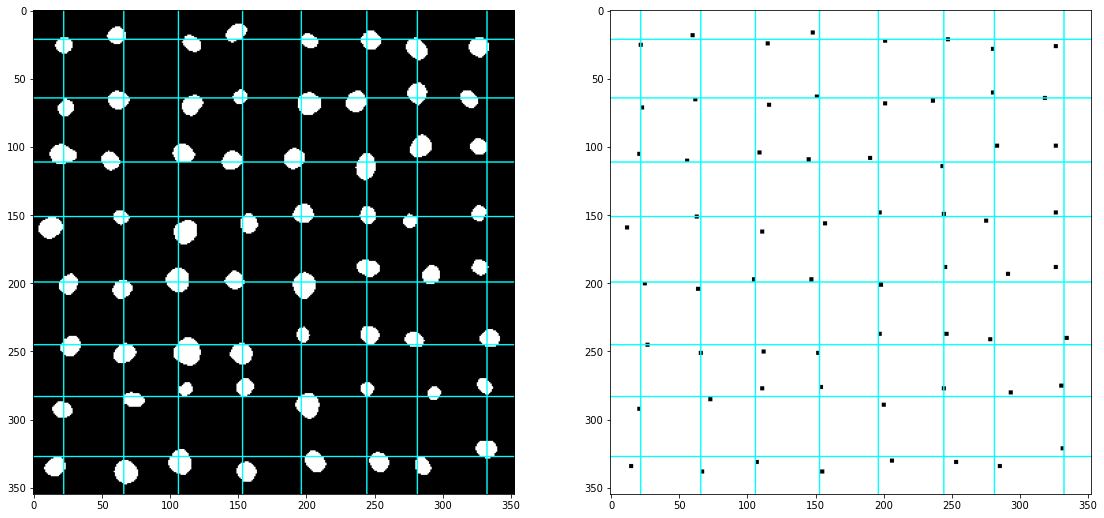

In [20]:
from PIL import ImageDraw

def add_virtual_lines(image, values_x, values_y):
    virtual_lines = image.convert(mode='RGB')
    drawer = ImageDraw.Draw(virtual_lines)
    color = (0, 255, 255)
    for x in values_x:
        drawer.line([((x), 0), ((x), virtual_lines.height)], fill=color, width=1)

    for y in values_y:
        drawer.line([(0, int(y)), (virtual_lines.width, int(y))], fill=color, width=1)
    
    return virtual_lines

plot_images([
    (add_virtual_lines(deleted_noise_image, average_x, average_y), ''),
    (add_virtual_lines(centroids_image, average_x, average_y), '')
])